<h1>Результаты A/A/B-теста<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Загрузска-данных-и-предобработка" data-toc-modified-id="Загрузска-данных-и-предобработка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Загрузска данных и предобработка</a></span></li><li><span><a href="#Исследовательский-анализ-данных." data-toc-modified-id="Исследовательский-анализ-данных.-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Исследовательский анализ данных.</a></span></li><li><span><a href="#Воронка-событий." data-toc-modified-id="Воронка-событий.-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Воронка событий.</a></span></li><li><span><a href="#Результаты-эксперемента" data-toc-modified-id="Результаты-эксперемента-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Результаты эксперемента</a></span><ul class="toc-item"><li><span><a href="#Проверка-А/А-теста" data-toc-modified-id="Проверка-А/А-теста-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Проверка А/А-теста</a></span></li></ul></li><li><span><a href="#Результаты-A/B-теста" data-toc-modified-id="Результаты-A/B-теста-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Результаты A/B-теста</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Выводы</a></span></li></ul></div>

Исследование посвящено изучению поведения пользователей мобильного приложения по продаже продуктов питания. Работа будет основываться на датафрейме с результатами A/A/B-теста проведенного в связи с изменением шрифтов. 

Описание данных:  
Каждая запись в логе — это действие пользователя, или событие.   
EventName — название события;  
DeviceIDHash — уникальный идентификатор пользователя;  
EventTimestamp — время события;  
ExpId — номер эксперимента: 246 и 247 — контрольные группы, а 248 — экспериментальная.  

## Загрузска данных и предобработка

In [1]:
import pandas as pd
import datetime as dt
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import math as mth
from scipy import stats as st
import scipy.stats as stats

In [2]:
def get_info(dataframe):
    display(dataframe.head(5))
    print()
    dataframe.info()
    print()
    print(f"Явных дубликатов: {dataframe.duplicated().sum()}")
    print()
    print('Пропусков в колонках:')
    print(dataframe.isna().sum())

In [3]:
data = pd.read_csv('/datasets/logs_exp.csv', sep='\t')
data = data.rename(columns={'EventName':'event_name', 'DeviceIDHash':'device_id', 'EventTimestamp':'event_time', 'ExpId':'exp_id'})
get_info(data)

,event_name,device_id,event_time,exp_id
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   event_name  244126 non-null  object
 1   device_id   244126 non-null  int64 
 2   event_time  244126 non-null  int64 
 3   exp_id      244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB

Явных дубликатов: 413

Пропусков в колонках:
event_name    0
device_id     0
event_time    0
exp_id        0
dtype: int64


В нашем распоряжении один датафрейм с результатами A/A/B-теста. В нем 4 колонки и 244126 строк.  Обнаружено 413 дубликатов, посчитаем их долю от общего числа данных. Если дубликатов меньше 5% удалим их. 

In [4]:
print((data.duplicated().sum() / len(data.index.tolist()) * 100).round(2), '%')
data = data.drop_duplicates().reset_index(drop=True)
data.duplicated().sum()

0.17 %


0

Изменим тип даты у столбца с датой и временем. Добавим столбец с датой.

In [5]:
data['event_time'] = pd.to_datetime(data['event_time'], unit='s')
data['event_dt'] = pd.to_datetime(data['event_time']).dt.date
data.head()

,event_name,device_id,event_time,exp_id,event_dt
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,246,2019-07-25
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,246,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
3,CartScreenAppear,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,2019-07-25 11:48:42,248,2019-07-25


**В ходе предобработки данных мы привели названия столбцов к змеиному регистру, изменили типы данных в столбце с датой и временем, удалили дубликаты и добавили новый столбец с датой.**

## Исследовательский анализ данных.

Начнем исследование данных

In [6]:
data['event_name'].count().sum()

243713

Всего в таблице 243713 событий.

In [7]:
print('Уникальных пользователей в логе:', data['device_id'].nunique())
print('В среднем событий на пользователя:',data.groupby('device_id')['event_name'].count().mean().round(2))

Уникальных пользователей в логе: 7551
В среднем событий на пользователя: 32.28


          device_id  event_count
count  7.551000e+03  7551.000000
mean   4.677319e+18    32.275593
std    2.655343e+18    65.154219
min    6.888747e+15     1.000000
25%    2.397700e+18     9.000000
50%    4.688022e+18    20.000000
75%    7.007353e+18    37.000000
max    9.222603e+18  2307.000000
[ 64.   89.  200.5]


,device_id,event_count
5116,6304868067479728361,2307
147,197027893265565660,1998
3714,4623191541214045580,1768
5590,6932517045703054087,1439
1391,1754140665440434215,1221


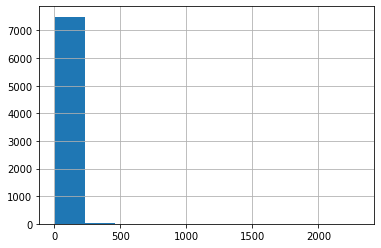

In [8]:
active = data.groupby('device_id')['event_name'].count().reset_index()
active.columns = ['device_id', 'event_count']
print(active.describe())
active['event_count'].hist()
print(np.percentile(active['event_count'], [90, 95, 99]))
active.sort_values(by = ['event_count'], ascending=False).head(5)

Большинство пользователей совершает менее 50 переходов между страницами интернет магаина. Есть несколько пользователей с аномальной активностью.

In [9]:
list_active_users = active.query('event_count > 200')
list_active_users = list_active_users['device_id']
print((len(list_active_users) / len(data)) * 100)
data = data.query('device_id not in @list_active_users')
data.groupby('device_id')['event_name'].count().sort_values(ascending=False).head(5)

0.031184220784283154


device_id
7086945417901847497    199
3807928414254040303    199
3488844663662468837    198
7610224088593907423    198
2438520924615884865    195
Name: event_name, dtype: int64

Мы выявили 1% сверхактивных пользователей и удалили их (удаленные данные не превышали 0,5% от всего массива), чтобы они не искажали исследование.

In [10]:
print('Минимальная дата:',  data['event_dt'].min())
print('Максимальная дата:' , data['event_dt'].max())
print('Период:' , data['event_time'].max() - data['event_time'].min())

Минимальная дата: 2019-07-25
Максимальная дата: 2019-08-07
Период: 13 days 16:31:41


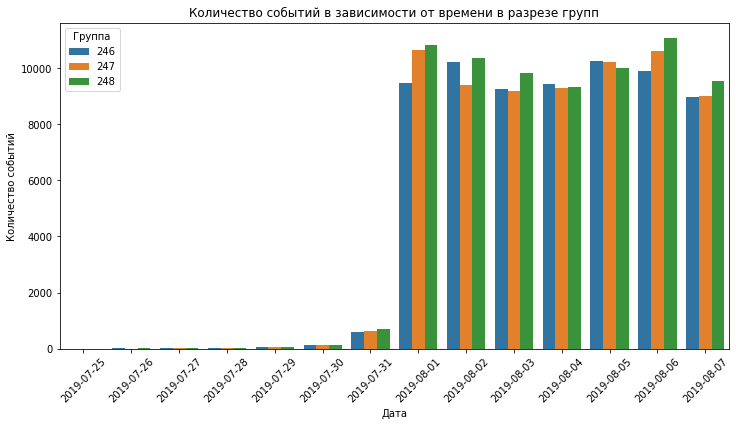

In [11]:
event_counts = data.groupby(['event_dt', 'exp_id'])['event_name'].count().reset_index()
plt.figure(figsize=(12, 6))
sns.barplot(data=event_counts, x='event_dt', y='event_name', hue='exp_id')
plt.title('Количество событий в зависимости от времени в разрезе групп')
plt.xlabel('Дата')
plt.ylabel('Количество событий')
plt.xticks(rotation=45)
plt.legend(title='Группа')
plt.show()

В датафрейме имеются данные почти за две недели с 25 июля по 7 августа 2019 года. На графике мы видим, что распределиние данных крайне неравномерное: данных за первую неделю значительно меньше, чем за вторую. Технически в логи новых дней по некоторым пользователям могут «доезжать» события из прошлого — это может «перекашивать данные». Удалим дни с неполными данными.

In [12]:
df = data.query('event_dt >= datetime(2019, 8, 1).date()')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 206615 entries, 2826 to 243712
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   event_name  206615 non-null  object        
 1   device_id   206615 non-null  int64         
 2   event_time  206615 non-null  datetime64[ns]
 3   exp_id      206615 non-null  int64         
 4   event_dt    206615 non-null  object        
dtypes: datetime64[ns](1), int64(2), object(2)
memory usage: 9.5+ MB


In [13]:
print('Событий до фильтрации:', data['event_time'].count())
print('Событий после фильтрации:', df['event_time'].count())
print('Доля удалённых событий:', ((data['event_time'].count() -  df['event_time'].count()) 
                                  / data['event_time'].count() * 100).round(2), '%')
print()
print('Уникальных пользователей в логе до фильтрации:', data['device_id'].nunique())
print('Уникальных пользователей в логе после фильтрации:', df['device_id'].nunique())
print('Доля удалённых пользователей:', ((data['device_id'].nunique() -  df['device_id'].nunique()) 
                                        / data['device_id'].nunique() * 100), '%')

Событий до фильтрации: 209333
Событий после фильтрации: 206615
Доля удалённых событий: 1.3 %

Уникальных пользователей в логе до фильтрации: 7475
Уникальных пользователей в логе после фильтрации: 7458
Доля удалённых пользователей: 0.2274247491638796 %


In [14]:
df.groupby('exp_id')['event_time'].count()

exp_id
246    67412
247    68295
248    70908
Name: event_time, dtype: int64

По результатам фильтрации было удаленно чуть больше 1% данных при допустимых 5%. В отфильтрованном датафрейме присутсвуют данные обо всех группах пользователей.

**В ходе исследовательского анализа данных был выявлен период наиболее полных результатов теста, были удалены неполные данные (1%). В итоге в нашем распоряжении данные за одну неделю 1 августа по7 августа 2019 года.** 

## Воронка событий.

In [15]:
df.groupby('event_name')['device_id'].count().sort_values(ascending=False)

event_name
MainScreenAppear           113264
OffersScreenAppear          40956
CartScreenAppear            29250
PaymentScreenSuccessful     22164
Tutorial                      981
Name: device_id, dtype: int64

Из этой таблицы мы видим 5 типов событий: 
- "MainScreenAppear" - переход на главный экран;
- "OffersScreenAppear" - переход на экран с товарами; 
- "CartScreenAppear" - переход в корзину; 
- "PaymentScreenSuccessful" - экран успешной оплаты; 
- "Tutorial" - переход на страницу с инструкциями.

In [16]:
df_funnel = df.pivot_table(index='event_name', values='device_id', aggfunc=['count', 'nunique']).reset_index()
df_funnel.columns = ['event_name', 'total_users', 'event_u']
df_funnel['ratio'] = (df_funnel['event_u'] / (df['device_id'].nunique()) * 100).apply(lambda x: f"{x:.2f}%")
df_funnel = df_funnel.sort_values(by='total_users', ascending=False)
df_funnel

,event_name,total_users,event_u,ratio
1,MainScreenAppear,113264,7344,98.47%
2,OffersScreenAppear,40956,4517,60.57%
0,CartScreenAppear,29250,3658,49.05%
3,PaymentScreenSuccessful,22164,3463,46.43%
4,Tutorial,981,824,11.05%


В таблице три столбца:
- total_users - все пользователи
- event_u - пользователи совершившие преход на данный экран
- ratio - отношение уникальных пользователей перешедших на экран события к общему числу уникальных пользователей.
Если строить путь пользователей, для начала стоит отметить, что tutorial очевидно в него не входит, это опциональное событие. Из этого следует, что последовательная цепочка выглядит следующим образом:

MainScreenAppear -> OffersScreenAppear -> CartScreenAppear -> PaymentScreenSuccessful		

In [17]:
df_funnel = df_funnel.query('event_name != "Tutorial"')
df_funnel['conversion'] = (df_funnel['event_u'] / df_funnel['event_u'].shift(1) * 100).fillna(100).apply(lambda x: f"{x:.2f}%")
df_funnel

/tmp/ipykernel_206/3642409707.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_funnel['conversion'] = (df_funnel['event_u'] / df_funnel['event_u'].shift(1) * 100).fillna(100).apply(lambda x: f"{x:.2f}%")


,event_name,total_users,event_u,ratio,conversion
1,MainScreenAppear,113264,7344,98.47%,100.00%
2,OffersScreenAppear,40956,4517,60.57%,61.51%
0,CartScreenAppear,29250,3658,49.05%,80.98%
3,PaymentScreenSuccessful,22164,3463,46.43%,94.67%


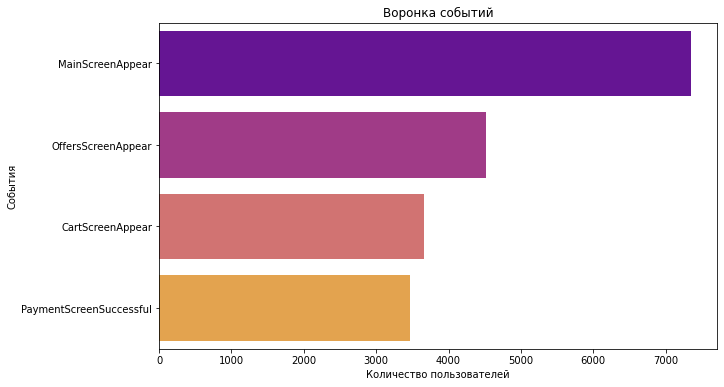

In [18]:
plt.figure(figsize=(10, 6))
sns.barplot(x='event_u', y='event_name', data=df_funnel, palette='plasma')
plt.title('Воронка событий')
plt.xlabel('Количество пользователей')
plt.ylabel('События')
plt.show()

In [19]:
print('Доходит от первого события до оплаты:', 
      (df_funnel.loc[3,'event_u'] / df_funnel.loc[1,'event_u']*100).round(2), '% пользователей')

Доходит от первого события до оплаты: 47.15 % пользователей


**Большее число потерь пользователей происходит при переходе на второй шаг: OffersScreenAppear (переход на экран с товарами). Из тех кто перешел на этот шаг, на следующий переходит чуть больше 80%, на экран успешной оплаты переходит почти 95% пользователей перешедших в корзину.**

## Результаты эксперемента

### Проверка А/А-теста

Приступим к непосредственному анализу результатов теста.

In [20]:
groups = df.groupby('exp_id')['device_id'].nunique()

В группах есть незначительная разница в количестве участников. Проверим находят ли статистические критерии разницу между контрольными группами.
Некоторые критерии успешного A/A-теста: 
- Попавший в одну из групп посетитель остаётся в этой группе до конца теста;
- Количество пользователей в различных группах различается не более, чем на 1%;
- Различие ключевых метрик по группам не превышает 1% и не имеет статистической значимости.

In [21]:
id_doubles = df.groupby('device_id')['exp_id'].nunique()
id_doubles[id_doubles > 1].count()

0

В результатах теста нет пользователей, которые находятся сразу в двух групах.

In [22]:
print('Разница между группами 246 и 247:', ((groups.get(246, 0) - groups.get(247, 0)) / groups.get(247, 0) * 100).round(2), '%')

Разница между группами 246 и 247: -1.41 %


Разница между группами превышает 1%, но незначительно. Примем, что в рамках данного исследования это допустимо.

Выберем самое популярное событие. Посчитаем число пользователей, совершивших это событие в каждой из контрольных групп затем посчитаем долю пользователей, совершивших это событие.

In [23]:
total_users = df.pivot_table(index='exp_id', values='device_id', aggfunc='nunique').reset_index()
total_users.columns = ['exp_id', 'total_users']
m_event = df.query('event_name == "MainScreenAppear"')
m_event = m_event.pivot_table(index='exp_id', values='device_id', aggfunc='nunique').reset_index()
m_event.columns = ['exp_id', 'event_users']
m_event = m_event.join(total_users['total_users'])
m_event['ratio'] = (m_event['event_users'] / m_event['total_users'] * 100).apply(lambda x: f"{x:.2f}%")
m_event

,exp_id,event_users,total_users,ratio
0,246,2423,2456,98.66%
1,247,2454,2491,98.51%
2,248,2467,2511,98.25%


Теперь проверим, будет ли отличие между группами статистически достоверным. 

In [24]:
group_246 = df.query('exp_id == 246')
group_247 = df.query('exp_id == 247')
group_248 = df.query('exp_id == 248')
group_246_247 = df.query('exp_id < 248')

**Прежде чем приступать к тестам необходимо установить уровень значимости. Нам предстоят множественные проверки, поэтому вероятность ошибки увеличивается. Примем поправки уровня значимости по Бенферонни:**  
**Нам предстоит 20 проверок, значит формула будет выглядеть так:**   
**α / m = 0.05 / 20 = 0.0025**  
**Примем значение α=0.0025**

In [25]:
def z_test(group_1, group_2, event):
    alpha = 0.0025
    event_u = np.array([group_1[group_1['event_name'] == event]['device_id'].nunique(), 
                        group_2[group_2['event_name'] == event]['device_id'].nunique()])
    total_users = np.array([group_1['device_id'].nunique(), 
                        group_2['device_id'].nunique()])

    
    p1 = event_u[0]/total_users[0]
    p2 = event_u[1]/total_users[1]
    p_combined = (event_u[0] + event_u[1]) / (total_users[0] + total_users[1])
    difference = p1 - p2 

    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/total_users[0] + 1/total_users[1])) # ваш код
    distr = st.norm(0, 1)  
    p_value = (1 - distr.cdf(abs(z_value))) * 2
    print(event)
    print(f"P-value: {p_value:.4f}")
    if p_value < alpha:
        print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
    else:
        print('Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными')
    print()

Начнем проверки гипотез по каждому событию между группами 246 и 247:  
**Гипотеза H0:** между долями пользователей совершивших событие нет значимой разницы.  
**Гипотеза H1:** между долями пользователей совершивших событие есть значимая разница.

In [26]:
for event in df['event_name'].unique():
    z_test(group_246, group_247, event,)
    print()

Tutorial
P-value: 0.7815
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


MainScreenAppear
P-value: 0.6731
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


OffersScreenAppear
P-value: 0.2770
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


CartScreenAppear
P-value: 0.2630
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


PaymentScreenSuccessful
P-value: 0.1359
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными




**А/А тест признаем успешным по описанным выше критериям**

## Результаты A/B-теста

Проверки гипотез по каждому событию между группами 246 и 248:  
**Гипотеза H0:** между долями пользователей совершивших событие нет значимой разницы.  
**Гипотеза H1:** между долями пользователей совершивших событие есть значимая разница.

In [27]:
for event in df['event_name'].unique():
    z_test(group_246, group_248, event)
    print()

Tutorial
P-value: 0.9650
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


MainScreenAppear
P-value: 0.2438
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


OffersScreenAppear
P-value: 0.2175
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


CartScreenAppear
P-value: 0.0832
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


PaymentScreenSuccessful
P-value: 0.2239
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными




Начнем проверки гипотез по каждому событию между группами 247 и 248:  
**Гипотеза H0:** между долями пользователей совершивших событие нет значимой разницы.  
**Гипотеза H1:** между долями пользователей совершивших событие есть значимая разница.

In [28]:
for event in df['event_name'].unique():
    z_test(group_247, group_248, event)
    print()

Tutorial
P-value: 0.8142
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


MainScreenAppear
P-value: 0.4545
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


OffersScreenAppear
P-value: 0.8851
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


CartScreenAppear
P-value: 0.5397
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


PaymentScreenSuccessful
P-value: 0.7801
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными




Начнем проверки гипотез по каждому событию между объединенной группой 246-247 и группой 248:  
**Гипотеза H0:** между долями пользователей совершивших событие нет значимой разницы.  
**Гипотеза H1:** между долями пользователей совершивших событие есть значимая разница.

In [29]:
for event in df['event_name'].unique():
    z_test(group_246_247, group_248, event)
    print()

Tutorial
P-value: 0.9111
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


MainScreenAppear
P-value: 0.2619
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


OffersScreenAppear
P-value: 0.4280
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


CartScreenAppear
P-value: 0.1762
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


PaymentScreenSuccessful
P-value: 0.5909
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными




**По результатам A/B-тестирования значимых различий между требя группами не выявлено.**

## Выводы

В ходе исследования были изучены данные по результатам А/В- тестирования мобильного приложения по продаже продуктов питания.
В ходе предобработки данных названия столбцов были приведены к змеиному регистру, был изменен типы данных у столбца с датой и временем, удалены дубликаты и добавлен новый столбец с датой. 
В ходе исследовательского анализа данных был выявлен период наиболее полных результатов теста, были удалены неполные данные (1%).
Были сделаны следующие выводы:  
- При исследовании воронки был выявлен путь пользователя. Большее число потерь пользователей происходит при переходе на второй шаг: OffersScreenAppear (переход на экран с товарами). Из тех кто перешел на этот шаг, на следующий переходит чуть больше 80%, на экран успешной оплаты переходит почти 95% пользователей перешедших в корзину.
- Доходит от первого события до оплаты: 47.15 % пользователей.  
- Проведенный A/A-тест соответствует критериям успешности, а именно: Попавший в одну из групп посетитель остаётся в этой группе до конца теста; Количество пользователей в различных группах различается не более, чем на 1.2%; Различие ключевых метрик по группам не превышает 1% и не имеет статистической значимости;
- По результатам A/B-тестирования значимых различий между требя группами не выявлено. Новый шрифт не влияет на поведение пользователей. 

Рекомендации:  
Почти 40% пользователей не переходят с главного экрана на страницу просмотра товаров. Следуюет исследовать причины данного явления.